# Pressure-driven flow between parallel plates

## Overview

### Questions

- How can pressure-driven flow between parallel plates be simulated with MPCD?
- How can pressure-driven flow simulations be used to measure fluid properties?

### Objectives

- Demonstrate how to simulate and analyze pressure-driven flow.
- Describe wall slip and be able to identify it in simulation data.
- Explain how to extract the shear viscosity for a Newtonian fluid from a
  simulation of pressure-driven flow between parallel plates.

## Boilerplate code

In [1]:
import hoomd
import hoomd.azplugins
import hoomd.mpcd
import matplotlib
import numpy
import scipy.optimize

%matplotlib inline
matplotlib.style.use("ggplot")
import matplotlib_inline

matplotlib_inline.backend_inline.set_matplotlib_formats("svg")

## Background

Pressure-driven flow is created when a pressure gradient or force is applied to
the fluid. The classic example of this type of flow is pressure-driven flow
between parallel plates with no-slip boundary conditions, also called Poiseuille
flow or parabolic flow.

If the parallel plates are at $y = \pm H$ and a constant force $f_x$ is applied
to all MPCD particles in the $x$ direction, we expect the particles to flow in
only the *x* direction. Assuming the MPCD particles act as an incompressible
Newtonian fluid, the momentum balance that governs the flow, which is a
second-order ordinary differential equation, is:

$$
\mu \frac{{\rm d}^2 u_x}{{\rm d}y^2} + \rho f_x = 0
$$

where $\mu$ is the dynamic viscosity, $u_x$ is the velocity in the *x* direction,
and $\rho$ is the number density. The general solution to this differential
equation is:

$$
u_x = -\frac{\rho f_x}{2 \mu} y^2 + c_1 y + c_2
$$

where $c_1$ and $c_2$ are unknown coefficients. No slip at the boundaries means
that $u_x(\pm H) = 0$, so applying these conditions and solving for $c_1$ and
$c_2$ gives:

$$
u_x(y) = \frac{\rho f_x H^2}{2 \mu}\left[1 - \left(\frac{y}{H}\right)^2 \right],
    \quad -H \le y \le H
$$

Let's see if MPCD produces this result!

## Initialization

We setup the MPCD particles in the same parallel plate geometry we used for
wall-driven shear flow.

In [2]:
H = 10
L = 25
padding = 4

mass = 1
density = 5
kT = 1

rng = numpy.random.default_rng(seed=42)

snapshot = hoomd.Snapshot()
snapshot.configuration.box = [L, 2 * H + padding, L, 0, 0, 0]

snapshot.mpcd.types = ["A"]
snapshot.mpcd.N = int(density * (2 * H) * L**2)
snapshot.mpcd.mass = mass
snapshot.mpcd.position[:] = [0.5 * L, H, 0.5 * L] * rng.uniform(
    low=-1, high=1, size=(snapshot.mpcd.N, 3)
)

velocity = rng.normal(0.0, numpy.sqrt(kT / mass), (snapshot.mpcd.N, 3))
velocity -= numpy.mean(velocity, axis=0)
snapshot.mpcd.velocity[:] = velocity

simulation = hoomd.Simulation(device=hoomd.device.auto_select(), seed=1)
simulation.create_state_from_snapshot(snapshot)

## Configuring the MPCD integrator

The integrator setup also looks similar to the wall-driven shear flow. We attach
the same integrator, collision method, and particle sorter.

In [3]:
integrator = hoomd.mpcd.Integrator(dt=0.1)
integrator.collision_method = hoomd.mpcd.collide.StochasticRotationDynamics(
    period=1, angle=130, kT=kT
)
integrator.mpcd_particle_sorter = hoomd.mpcd.tune.ParticleSorter(
    trigger=20 * integrator.collision_method.period
)
simulation.operations.integrator = integrator

The main difference is that when we create the streaming method, we need to
add a body force that acts on the MPCD particles like we did to simulate
sedimentation. The parallel plates are also now going to be stationary.

In [4]:
fx = 0.004
plates = hoomd.mpcd.geometry.ParallelPlates(separation=2 * H, no_slip=True)
body_force = hoomd.mpcd.force.ConstantForce(force=(fx, 0, 0))
integrator.streaming_method = hoomd.mpcd.stream.BounceBack(
    period=1, geometry=plates, mpcd_particle_force=body_force
)

We also still need a virtual-particle filler.

In [5]:
filler = hoomd.mpcd.fill.GeometryFiller(
    type="A", density=density, kT=kT, geometry=plates
)
integrator.virtual_particle_fillers.append(filler)

## Velocity field

### Warmup

We again need to warmup the flow field: it takes time for the particles to
feel the applied force and come to steady state. We can check the kinetic
energy associated with the *x* component of the particle velocities.

In [6]:
num_samples = 500
num_steps_per_sample = 10
times = numpy.zeros(num_samples, dtype=int)
kinetic_energy = numpy.zeros(num_samples)
for i in range(num_samples):
    simulation.run(num_steps_per_sample)

    snapshot = simulation.state.get_snapshot()
    times[i] = simulation.timestep * integrator.dt
    kinetic_energy[i] = (
        0.5 * snapshot.mpcd.mass * numpy.sum(snapshot.mpcd.velocity[:, 0]**2)
    )

It takes longer for this pressure-driven flow to reach its steady state than
the wall-driven flow we simulated before.

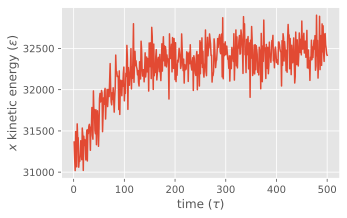

In [7]:
fig = matplotlib.figure.Figure(figsize=(5, 3.09))
ax = fig.add_subplot()
ax.plot(times, kinetic_energy)
ax.set_xlabel(r"time ($\tau$)")
ax.set_ylabel(r"$x$ kinetic energy ($\varepsilon$)")
fig

### Production

Now that we've warmed up, we can go ahead with measuring the average flow field
using the same strategy as for the wall-driven shear flow. We use the same type
of velocity compute:

In [8]:
bin_size = 0.5
num_bins = numpy.round((2 * H) / bin_size).astype(int)
velocity_field = hoomd.azplugins.compute.CartesianVelocityFieldCompute(
    num_bins=(0, num_bins, 0),
    lower_bounds=(0, -H, 0),
    upper_bounds=(0, H, 0),
    include_mpcd_particles=True
)
simulation.operations.computes.append(velocity_field)

and the same sampling strategy, but a little longer this time to get better
data for some of our subsequent analysis.

In [9]:
num_samples = 1000
num_steps_per_sample = 10
for i in range(num_samples):
    simulation.run(num_steps_per_sample)

    # size the array the first time
    if i == 0:
        avg_velocity_field = numpy.zeros(velocity_field.velocities.shape)

    # accumulate x velocity
    avg_velocity_field += velocity_field.velocities
avg_velocity_field /= num_samples

We confirm that there is no flow in *y* or *z*, but there is in the *x* direction.

In [10]:
numpy.max(numpy.abs(avg_velocity_field), axis=0)

array([0.26369117, 0.0015928 , 0.00460512])

Let's compare the *x* velocity $u_x$ that we simulated to the theortical
expectation. First, we need an estimate of the dynamic viscosity. The
theoretical formulas from our introduction to MPCD give
$3.96 \varepsilon \tau/\ell^3$.

In [11]:
dynamic_viscosity = 3.96

What do you notice about how the two compare?

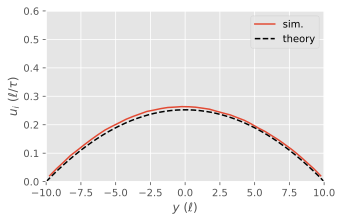

In [12]:
fig = matplotlib.figure.Figure(figsize=(5, 3.09))
ax = fig.add_subplot()

# simulated flow field
y = velocity_field.coordinates
ux = avg_velocity_field[:, 0]
ax.plot(y, ux, label="sim.")

# theoretical flow field
y_theory = numpy.linspace(-H, H)
u_theory = (0.5 * density * fx * H**2 / dynamic_viscosity) * (1 - (y_theory / H)**2)
ax.plot(y_theory, u_theory, "k--", label="theory")

ax.set_xlabel(r"$y$ ($\ell$)")
ax.set_xlim([-H, H])
ax.set_ylabel(r"$u_i$ ($\ell/\tau$)")
ax.set_ylim([0, 0.6])
ax.legend()
fig

The simulated velocity field seems to be shifted up a bit compared to the
theoretical one. This is another signature of **wall slip**. Even though we are
trying to enforce no-slip boundary conditions at the parallel plate surfaces,
we can see that the simulated velocity field is not exactly zero there.
There is usually a small amount of slip present in MPCD, and it becomes more
apparent as the overall flow velocity increases.

*Question*: How big is the slip velocity in the simulations compared to the
maximum velocity? For a quick estimate, try subtracting a small number from the
simulated velocity to match it by eye to the theoretical one. The value you
subtracted is an estimate of the slip velocity. 

## Extracting viscosity

We assumed we knew the dynamic viscosity, but we can also use our simulation
data to extract an estimate of the viscosity. In principle, we can fit the
general solution for $u_x$ to the measured one, without assuming no-slip
boundary conditions, but the fit will have 3 parameters. It is usually easier
and better to fit fewer parameters if possible.

To do so, we can work with the first derivative of the general solution for $u_x$
with respect to *y*:

$$
\frac{{\rm d} u_x}{{\rm d}y} = -\frac{\rho f_x}{\mu} y + c_1
$$

This only has two fitting parameters: $\mu$ and $c_1$. However, the flow is
expected to be symmetric and have its maximum at the center, where $y = 0$,
because both parallel plates are the same. This means that $c_1$ must be zero.
Hence, we can fit only the viscosity $\mu$!

We first need the derivative of $u_x$ from our simulation data. NumPy has a
convenient method for doing so:

In [13]:
dux_dy = numpy.gradient(ux, y)

We will use [scipy.optimize.curve_fit](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html)
to fit the data and extract the viscosity. It gives us both an estimate of the
parameter as well as an uncertainty in the fit.

In [14]:
def line(y, mu):
    return -(density * fx / mu) * y

popt, pcov = scipy.optimize.curve_fit(line, y, dux_dy)
dynamic_viscosity_fit = popt[0]
dynamic_viscosity_uncertainty = numpy.sqrt(pcov[0, 0])
print(f"{dynamic_viscosity_fit:.2f} +/- {dynamic_viscosity_uncertainty:.2f}")

3.93 +/- 0.02


We get a viscosity that is in pretty good agreement with the theoretical
prediction! To be safe, let's confirm that the ${\rm d}u_x/{\rm d}y$ is
actually linear in $y$ and that our fit is decent by plotting the two together.

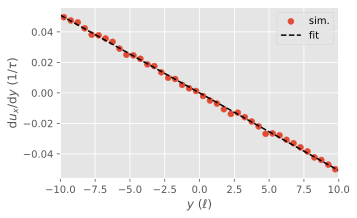

In [15]:
fig = matplotlib.figure.Figure(figsize=(5, 3.09))
ax = fig.add_subplot()

# simulated flow field
ax.scatter(velocity_field.coordinates, dux_dy, label="sim.")

ax.plot(y_theory, line(y_theory, dynamic_viscosity_fit), "k--", label="fit")

ax.set_xlabel(r"$y$ ($\ell$)")
ax.set_xlim([-H, H])
ax.set_ylabel(r"${\rm d}u_x/{\rm d}y$ ($1/\tau$)")
ax.legend()
fig

This looks overall quite good and linear for all values of *y*. There is still
some scatter in the simulation data, which is expected because these are
relatively short runs. Taking the derivative also exacerbates statistical noise.
To improve the fit, we should collect some more data.

## Additional activities

1. What is the maximum velocity in the simulations? How does it compare to the
   theoretical expectation?
2. What is the mean velocity $U_x$ in the simulations? How does it compare to
   the theoretical expectation? (Hint: use integration to get the mean of the
   theoretically expected flow field.)
3. What is the volumetric flow rate in the simulations? How does it compare to
   the theoretical expectation? The volumetric flow rate is defined as
   $Q = U_x A$, where $A$ is the cross-sectional area.
4. How does the flow field change if you also put the walls in motion? Can you
   make a theoretical prediction for what it should be? Hint: the boundary
   conditions will now be $u_x(\pm H) = \pm U$ if the walls have velocity $U$.